# Introduction

This notebook is for generating plots for Chapter 4.1 (Experimental Results, Synthetic Data - Binary).

It generates plots for decision boundaries of different linear binary classifiers for 2D data, learned from different loss functions.

For both a) separable and b) overlapping and both i) balanced and ii) imbalanced data.

# Imports and set-up

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import List
import itertools
import os

In [2]:
import matplotlib.pylab as pylab

params = {
    "legend.fontsize": "x-large",
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)

Use GPU if available

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device")
print("-" * 60)
print(device)

Device
------------------------------------------------------------
cuda:0


Create data directory, if it doesn't exist.

In [25]:
if not os.path.exists("../data"):
    os.makedirs("../data")

# Helper functions

Plotting function, extract weights and biases from model, training loop.

## Model functions

* Get weights and biases from model

In [6]:
def getwb(model, add: List[float] = [0, 0], mult: List[float] = [1, 1]):
    """Takes in binary LinearClassifier that has been fitted. Returns the weights and
    biases of the two classes.

    Args:
        model (LinearClassifier): Linear Classifier
        add (list, optional): Optional post-hoc addition to model's biases. Defaults to [0, 0].
        mult (list, optional): Optional post-hoc scaling of each discriminant function. Defaults to [1, 1].

    Returns:
        List[float]: The weights and biases of the model, post any offsets and scaling.
    """
    _model = model.cpu()

    return [
        _model.linear.weight[0].detach().numpy() / mult[0],
        _model.linear.weight[1].detach().numpy() / mult[1],
        (_model.linear.bias[0].detach().numpy() + add[0]) / mult[0],
        (_model.linear.bias[1].detach().numpy() + add[1]) / mult[1],
    ]

In [7]:
def modelTrain(
    model, optimizer, criterion, X_train, y_train, adjust: torch.Tensor = None
):
    """Trains a Pytorch model with an optimizer and criterion.
    When evaluating the loss, an adjustment can be applied to the output of the model.

    Args:
        model: Model to be trained.
        optimizer: Pytorch optimizer.
        criterion: Loss function
        X_train: Training X dataset.
        y_train: Training y dataset.
        adjust (torch.Tensor, optional): Additive update to output of model. Defaults to 0.
    """
    adjust = torch.Tensor([0]).to(device) if adjust is None else adjust
    for _ in range(10000):
        # zero the gradients
        optimizer.zero_grad()

        # forward
        output = model(X_train)
        loss = criterion(output + adjust, y_train.view(-1))

        # backward
        loss.backward()

        # optimize
        optimizer.step()

    return model

## Plotting functions

* plot decision boundaries from weights and biases
* plot binary 2D data
* repeated plot formatting

In [8]:
def plot_db(wb: List[float], modelType: str = "[modelType]", lins="r"):
    """Plots decision boundary line where -4 <= x, y <= 4, given the weights
    and biases of the discriminant functions for each class. Options for
    plot title and linestyle.

    Args:
        wb (List[float]): List of weights and biases.
        modelType (str, optional): Label for plot. Defaults to '[modelType]'.
        lins (str, optional): Linestyle of plot. Defaults to 'r'.
    """

    w0, w1, b0, b1 = wb[0], wb[1], wb[2], wb[3]
    x0 = np.linspace(-4, 4, 100)
    x1 = (b1 - b0 - (w0[0] - w1[0]) * x0) / (w0[1] - w1[1])
    plt.plot(x0, x1, lins, label=f"{modelType}")

In [9]:
def binary_2d_data_plot(sampA, sampB, linsA="cx", linsB=".y"):
    """Create a 2D scatter plot of binary data points from two classes.

    Args:
        sampA (array-like): Data points from the first class to be plotted. It should be
            a 2D array where each row represents a data point, and the first column
            corresponds to the x-coordinate, and the second column corresponds to the
            y-coordinate.
        sampB (array-like): Data points from the second class to be plotted. It should be
            a 2D array with the same structure as `sampA`.
        linsA (str, optional): A string specifying the line style and color for sampA.
            Default is "cx" (cyan 'x' markers).
        linsB (str, optional): A string specifying the line style and color for sampB.
            Default is ".y" (yellow '.' markers).
    """
    plt.plot(sampA[:, 0], sampA[:, 1], linsA)
    plt.plot(sampB[:, 0], sampB[:, 1], linsB)

In [10]:
def models_to_plot(model_plot_configs: List[dict]):
    """
    Generate plots for a list of models based on their configurations.

    Args:
        model_plot_configs (List[dict]): A list of dictionaries, where each dictionary
            contains two key-value pairs:
            - "model_config": A dictionary containing the kwargs for getwb (i.e. the model, and any multiplicate or additive update)
            - "plot_config": A dictionary containing the kwargs for plot_db (i.e. plot title and linestyle)

    Returns:
        None
    """
    for model_plot_config in model_plot_configs:
        model_config = model_plot_config["model_config"]
        plot_config = model_plot_config["plot_config"]

        plot_db(wb=getwb(**model_config), **plot_config)

In [11]:
def plot_formatting(config: tuple, suffix: str):
    """Apply formatting to a matplotlib plot, set title, labels, and save the plot.

    Args:
        config (tuple): A tuple containing two Boolean values representing the plot
            configuration:
            - imbalanced: Whether the data is imbalanced (True) or balanced (False).
            - separable: Whether the data is separable (True) or overlapping (False).
        suffix (str): A suffix to be added to the saved plot file name.

    Returns:
        None
    """
    imbalanced, separable = config

    plt.legend(loc="best")
    plt.title(
        f"Decision boundaries - {'Separable' if separable else 'Overlapping'}",
        fontsize=25,
    )
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid()
    plt.axis("scaled")
    plt.axis([-4, 4, -4, 4])
    figure = plt.gcf()
    figure.set_size_inches(8, 8)
    plt.savefig(
        f"../data/{'imbal' if imbalanced else 'bal'}{'Sep' if separable else 'Overlap'}{suffix}.png",
        dpi=1200,
    )
    plt.show()

# Synthetic data generation and visualisation

10,000 samples

$ (100p)\% $ from Gaussian centered at 
$\begin{bmatrix}
-1 \\
-1
\end{bmatrix}$ 
with covariance $ \lambda I_2 $ where $ I_2 = \begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}$; 

the remaining $ (100(1-p))\% $ from Gaussian centered at $\begin{bmatrix}
1 \\
1
\end{bmatrix}$  with covariance $ \lambda I_2 $.

For a) separable, $ \lambda = 0.04 $, and for b) overlapping, $ \lambda = 1 $.

For i) balanced, $ p = 0.5 $, and for ii) imbalanced, $ p = 0.95 $.

In [12]:
"""
This dictionary will have 
* key = (imbalanced: boolean, separable) and 
* value = {
    "class_prob": list(float),
    "class_freq": list(int),
    "sampA": np.ndarray,
    "sampB": np.ndarray,
    "X_train": torch.Tensor, 
    "y_train": torch.Tensor,
}
class_prob is the list of class probabilities (length 2). Depends on imbalanced.
class_freq is the list of class frequencies (length 2). I.e. class_prob * |training set|. 
sampA is the data for the first class ('negative', around (-1,-1)). Variance of the features depends on separable.
sampB is the data for the second class ('positive', around (+1,+1)). Variance of the features depends on separable.
X_train, y_train are the features and labels from sampA and sampB concatenated, stored as torch Tensors.

Later the models for each dataset are added to the nested dictionaries.
"""

Xy_model_dict = {}

In [13]:
N = 10000

for imbalanced, separable in list(itertools.product(*[[True, False]] * 2)):
    config = (imbalanced, separable)
    Xy_model_dict[config] = {}

    Xy_model_dict[config]["class_prob"] = [0.95, 0.05] if imbalanced else [0.5, 0.5]
    Xy_model_dict[config]["class_freq"] = [
        int(N * i) for i in Xy_model_dict[config]["class_prob"]
    ]
    λ = 0.04 if separable else 1

    covariance = λ * np.identity(2)
    np.random.seed(2022)  # fix seed for a reproducable training set
    Xy_model_dict[config]["sampA"] = np.random.multivariate_normal(
        [-1, -1], covariance, Xy_model_dict[config]["class_freq"][0]
    )
    Xy_model_dict[config]["sampB"] = np.random.multivariate_normal(
        [1, 1], covariance, Xy_model_dict[config]["class_freq"][1]
    )
    np.random.seed()

    X_values = np.concatenate(
        (Xy_model_dict[config]["sampA"], Xy_model_dict[config]["sampB"]), axis=0
    )  # N-by-2 data matrix
    y_flat = np.array(
        [0] * Xy_model_dict[config]["class_freq"][0]
        + [1] * Xy_model_dict[config]["class_freq"][1]
    )  # row vector of labels

    index_shuffle = np.arange(len(X_values))
    np.random.shuffle(index_shuffle)

    # shuffle the rows of data matrix and labels

    X_values = X_values[index_shuffle]
    y_flat = y_flat[index_shuffle]

    # convert to Torch tensors

    X_train = torch.tensor(X_values).type(torch.FloatTensor).to(device)
    y_train = torch.from_numpy(y_flat).view(-1, 1).type(torch.LongTensor).to(device)

    Xy_model_dict[config] |= {"X_train": X_train, "y_train": y_train}

# Linear classifier

A very simple linear neural network with input dimension 2 and output dimension 2 (the discriminant function for each class)

In [14]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim=2, output_dim=2):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.linear(x)
        return x

In [15]:
# a base LinearClassifier. We make copies of this and train with different criteria and updates.

model_bin_orig = LinearClassifier().to(device)

# Training the classifiers

## Standard classifier

With single layer NN with Cross-Entropy Loss (for binary classification, this is equivalent to a sigmoid classifier)

In [23]:
for config in Xy_model_dict.keys():
    model_bin = deepcopy(model_bin_orig)

    optimizer_bin = torch.optim.SGD(model_bin.parameters(), lr=0.1, weight_decay=0)

    criterion_bin = nn.CrossEntropyLoss().to(device)

    Xy_model_dict[config]["trained_model_bin"] = modelTrain(
        model_bin,
        optimizer_bin,
        criterion_bin,
        Xy_model_dict[config]["X_train"],
        Xy_model_dict[config]["y_train"],
    )

## Loss modified

Balance the loss, by weighting it by: 
* the inverse of the class probability
* the inverse of the (Cui et. al) effective class frequencies

In [ ]:
for config in Xy_model_dict.keys():
    model_bin_bal = deepcopy(model_bin_orig)

    optimizer_bin_bal = torch.optim.SGD(
        model_bin_bal.parameters(), lr=0.1, weight_decay=0
    )

    criterion_bin_bal = nn.CrossEntropyLoss(
        weight=torch.tensor(np.reciprocal(Xy_model_dict[config]["class_prob"])).type(
            torch.FloatTensor
        )
    ).to(device)

    Xy_model_dict[config]["trained_model_bin_bal"] = modelTrain(
        model_bin_bal,
        optimizer_bin_bal,
        criterion_bin_bal,
        Xy_model_dict[config]["X_train"],
        Xy_model_dict[config]["y_train"],
    )

In [ ]:
beta = 0.999

for config in Xy_model_dict.keys():
    cui_weights = [
        (1 - beta) / (1 - beta**i) for i in Xy_model_dict[config]["class_freq"]
    ]  # inverse effective number for each class
    cui_weights = [i / sum(cui_weights) for i in cui_weights]  # normalise weights
    cui_weights = torch.tensor(cui_weights).type(torch.FloatTensor).to(device)

    model_bin_cui = deepcopy(model_bin_orig)

    optimizer_bin_cui = torch.optim.SGD(
        model_bin_cui.parameters(), lr=0.1, weight_decay=0
    )

    criterion_bin_cui = nn.CrossEntropyLoss(weight=cui_weights).to(device)

    Xy_model_dict[config]["trained_model_bin_cui"] = modelTrain(
        model_bin_cui,
        optimizer_bin_cui,
        criterion_bin_cui,
        Xy_model_dict[config]["X_train"],
        Xy_model_dict[config]["y_train"],
    )

## Cao's LDAM loss

In [27]:
# LDAM Loss taken from Cao et. al code and modified


class LDAMLoss(nn.Module):
    def __init__(self, class_prob, weight=None):
        super(LDAMLoss, self).__init__()
        delta = 1.0 / np.sqrt(np.sqrt(class_prob))
        delta = torch.FloatTensor(delta).to(device)
        self.delta = delta
        self.weight = weight

    def forward(self, outputs, target):
        # one-hot encodes the binary labels
        index = torch.zeros_like(outputs, dtype=torch.uint8).to(device)
        index.scatter_(1, target.data.view(-1, 1), 1)
        index_bool = index == 1
        index_float = index.type(torch.FloatTensor).to(device)

        # column vector of the margin adjustments
        batch_m = torch.matmul(self.delta[None, :], index_float.transpose(0, 1))
        batch_m = batch_m.view((-1, 1))

        # computes logits modified by subtracting the margin for each example (determined by the true class) from the each output for it
        outputs_m = outputs - batch_m

        # for each example, replace the logit for the true class by the modified one, and keep the others the same
        output = torch.where(index_bool, outputs_m, outputs)

        # computes the mean of cross-entropy losses for each example and its adjusted output
        return F.cross_entropy(output, target, weight=self.weight)

In [28]:
for config in Xy_model_dict.keys():
    model_bin_cao = deepcopy(model_bin_orig)

    optimizer_bin_cao = torch.optim.SGD(
        model_bin_cao.parameters(), lr=0.1, weight_decay=0
    )

    criterion_bin_cao = LDAMLoss(Xy_model_dict[config]["class_prob"])

    Xy_model_dict[config]["trained_model_bin_cao"] = modelTrain(
        model_bin_cao,
        optimizer_bin_cao,
        criterion_bin_cao,
        Xy_model_dict[config]["X_train"],
        Xy_model_dict[config]["y_train"],
    )

## Equalised Loss

In [29]:
# Loss with margin log(pi_j) for where j is the negative class


class EqLoss(nn.Module):
    def __init__(self, class_prob, weight=None):
        super(EqLoss, self).__init__()
        delta = np.log(class_prob)
        delta = torch.FloatTensor(delta).to(device)
        self.delta = delta
        self.weight = weight

    def forward(self, outputs, target):
        # one-hot encodes the binary labels
        index = torch.zeros_like(outputs, dtype=torch.uint8).to(device)
        index.scatter_(1, target.data.view(-1, 1), 1)
        index_bool = index == 1

        # column vector of the margin adjustments
        batch_m = self.delta.repeat(outputs.shape[0], 1)

        # computes logits modified by adding the margin, log(pi_j), to each logit f_j for each example
        outputs_m = outputs + batch_m

        # for each example, replace the logit for the negative classes by the modified one in outputs_m, and keep original logit for true class
        output = torch.where(index_bool, outputs, outputs_m)

        # computes the mean of cross-entropy losses for each example and its adjusted output
        return F.cross_entropy(output, target, weight=self.weight)

In [30]:
for config in Xy_model_dict.keys():
    model_bin_eq = deepcopy(model_bin_orig)

    optimizer_bin_eq = torch.optim.SGD(
        model_bin_eq.parameters(), lr=0.1, weight_decay=0
    )

    criterion_bin_eq = EqLoss(Xy_model_dict[config]["class_prob"])

    Xy_model_dict[config]["trained_model_bin_eq"] = modelTrain(
        model_bin_eq,
        optimizer_bin_eq,
        criterion_bin_eq,
        Xy_model_dict[config]["X_train"],
        Xy_model_dict[config]["y_train"],
    )

## Logit-Adjusted Loss

In [31]:
for config in Xy_model_dict.keys():
    la_margin_mat = (
        torch.Tensor(np.array([np.log(Xy_model_dict[config]["class_prob"])] * N))
        .type(torch.float32)
        .to(device)
    )

    model_bin_la = deepcopy(model_bin_orig)

    optimizer_bin_la = torch.optim.SGD(
        model_bin_la.parameters(), lr=0.1, weight_decay=0
    )

    criterion_bin_la = nn.CrossEntropyLoss()

    Xy_model_dict[config]["trained_model_bin_la"] = modelTrain(
        model_bin_la,
        optimizer_bin_la,
        criterion_bin_la,
        Xy_model_dict[config]["X_train"],
        Xy_model_dict[config]["y_train"],
        adjust=la_margin_mat,
    )

# Plot the decision boundaries

Decision boundaries for each linear classifier (Vanilla ERM, logit-adjusted, reweighted and modified loss).

We also include the Bayes classifier decision boundaries (y = - x).

## Weighted loss

In [ ]:
for config in Xy_model_dict.keys():
    # Plot the decision boundaries - can plot boundaries for different models

    imbalanced, separable = config

    binary_2d_data_plot(
        sampA=Xy_model_dict[config]["sampA"],
        sampB=Xy_model_dict[config]["sampB"],
        linsA="cx",
        linsB=".y",
    )

    models_to_plot(
        [
            {
                "model_config": {
                    "model": Xy_model_dict[config]["trained_model_bin"],
                },
                "plot_config": {"modelType": "β = 0", "lins": "r"},
            },
            {
                "model_config": {
                    "model": Xy_model_dict[config]["trained_model_bin_cui"],
                },
                "plot_config": {"modelType": f"β = {beta}", "lins": "b"},
            },
            {
                "model_config": {
                    "model": Xy_model_dict[config]["trained_model_bin_bal"],
                },
                "plot_config": {"modelType": "β = 1", "lins": "g"},
            },
        ]
    )
    plot_db([[0, 0], [1, 1], 0, 0], modelType="Bayes classifier", lins="k--")

    plot_formatting(config=config, suffix="Weighted")

## Logit adjusted

In [ ]:
for config in Xy_model_dict.keys():
    imbalanced, separable = config

    binary_2d_data_plot(
        sampA=Xy_model_dict[config]["sampA"],
        sampB=Xy_model_dict[config]["sampB"],
        linsA="cx",
        linsB=".y",
    )

    models_to_plot(
        [
            {
                "model_config": {
                    "model": Xy_model_dict[config]["trained_model_bin"],
                    "mult": Xy_model_dict[config]["class_prob"],
                },
                "plot_config": {"modelType": "Multiplicative update", "lins": "g"},
            },
            {
                "model_config": {
                    "model": Xy_model_dict[config]["trained_model_bin"],
                    "add": -np.log(Xy_model_dict[config]["class_prob"]),
                },
                "plot_config": {"modelType": "Additive update", "lins": "b"},
            },
            {
                "model_config": {
                    "model": Xy_model_dict[config]["trained_model_bin"],
                },
                "plot_config": {"modelType": "ERM", "lins": "r"},
            },
        ]
    )

    plot_db([[0, 0], [1, 1], 0, 0], modelType="Bayes classifier", lins="k--")

    plot_formatting(config=config, suffix="Update")

## Margin adjusted loss

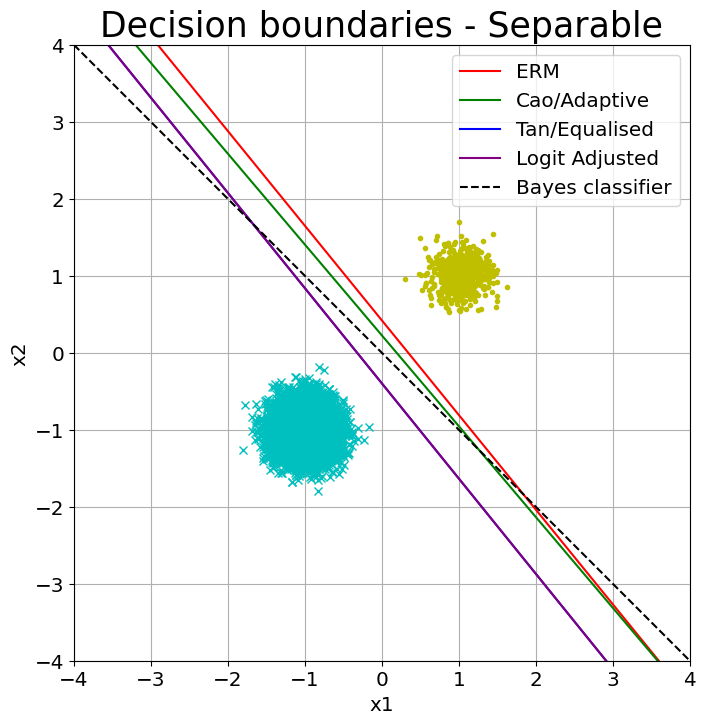

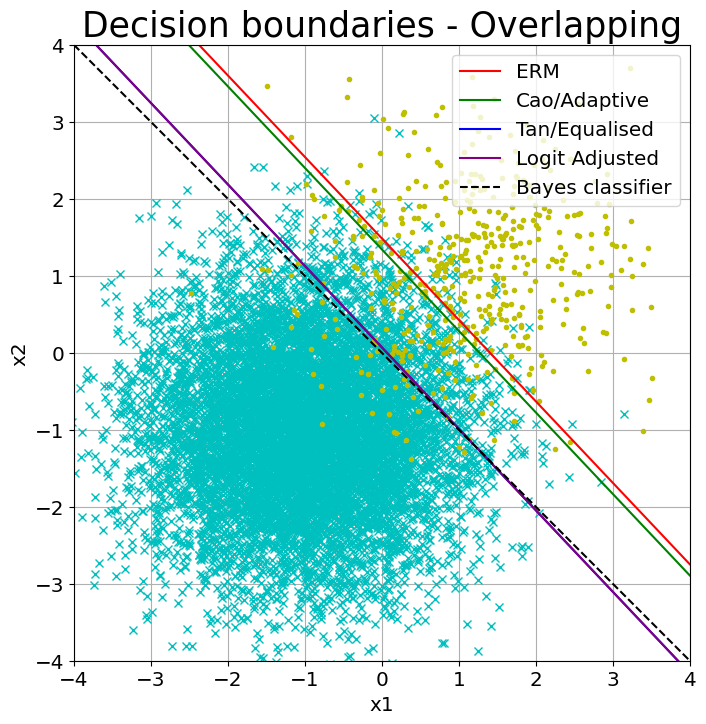

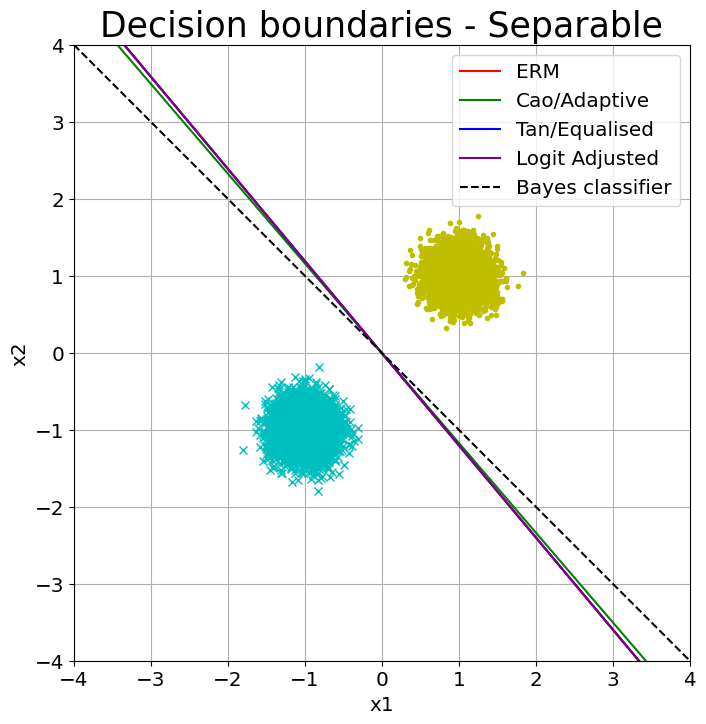

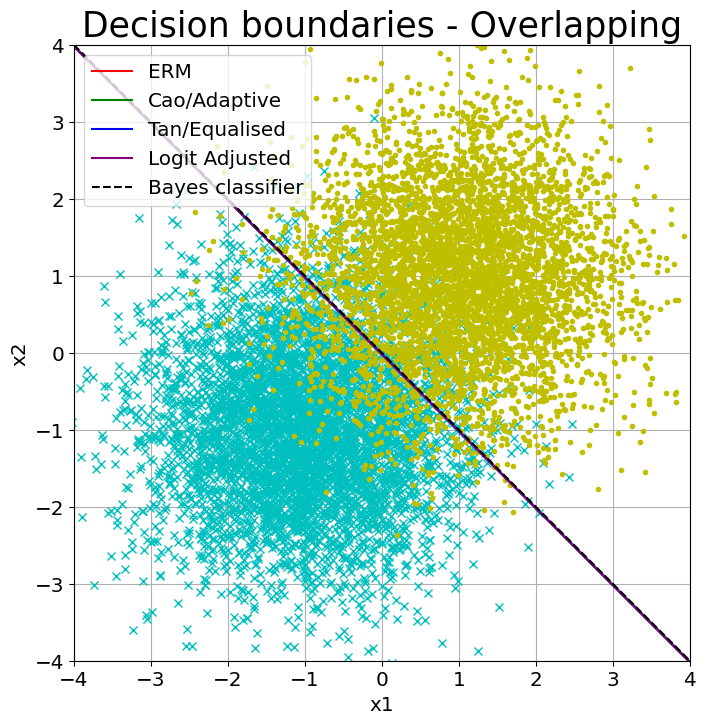

In [32]:
for config in Xy_model_dict.keys():
    imbalanced, separable = config

    binary_2d_data_plot(
        sampA=Xy_model_dict[config]["sampA"],
        sampB=Xy_model_dict[config]["sampB"],
        linsA="cx",
        linsB=".y",
    )

    models_to_plot(
        [
            {
                "model_config": {
                    "model": Xy_model_dict[config]["trained_model_bin"],
                },
                "plot_config": {"modelType": "ERM", "lins": "r"},
            },
            {
                "model_config": {
                    "model": Xy_model_dict[config]["trained_model_bin_cao"],
                },
                "plot_config": {"modelType": "Cao/Adaptive", "lins": "g"},
            },
            {
                "model_config": {
                    "model": Xy_model_dict[config]["trained_model_bin_eq"],
                },
                "plot_config": {"modelType": "Tan/Equalised", "lins": "b"},
            },
            {
                "model_config": {
                    "model": Xy_model_dict[config]["trained_model_bin_la"],
                },
                "plot_config": {"modelType": "Logit Adjusted", "lins": "purple"},
            },
        ]
    )
    plot_db([[0, 0], [1, 1], 0, 0], modelType="Bayes classifier", lins="k--")

    plot_formatting(config=config, suffix="Margin")